# 2D Lung Segmentation for Deeblabv1

According to the World Heath Organization, lung cancer is the leading cause of cancer-related deaths worldwide, accounting for an estimated 1.4 million deaths in 2018 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3864624/). CT scans are now being used in the United States to screen high-risk individuals for lung cancer. In order to detect cancerous lesions in scans, a useful first step is to segment the lungs in the image. (Then a researcher would use just the segmented image as input to another model). In this notebook we will perform segmentation on lungs in CT scans using a U-Net model (https://sites.pitt.edu/~sjh95/related_papers/u-net.pdf).


In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3  # silence some TensorFlow warnings and logs.

import os
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.model_selection import train_test_split

# Please feel free to play with hyperparameters, but submit the assignment with the original values.
IMAGE_SIZE = (128, 128)
TRAIN_VAL_TEST_SPLIT = (0.6, 0.2, 0.2)
BATCH_SIZE = 16
SEED = 220
EPOCHS = 40

env: TF_CPP_MIN_LOG_LEVEL=3  # silence some TensorFlow warnings and logs.


## Section 1: Data

We will be using a Kaggle dataset from https://www.kaggle.com/kmader/finding-lungs-in-ct-data. Similar to part 1, create an API token to set in your environment and download the dataset from Kaggle through the following commands.

```kaggle datasets download -d kmader/finding-lungs-in-ct-data```

```unzip finding-lungs-in-ct-data.zip```

This should take a couple of minutes. Fill IMAGE_DIR and MASK_DIR with the output paths.

In [2]:
# FILL IN CODE HERE #

IMAGE_DIR = '/Users/sehwanyoo/Desktop/datasets/2d_lung/archive/2d_images' # replace with your path
MASK_DIR = '/Users/sehwanyoo/Desktop/datasets/2d_lung/archive/2d_masks' # replace with your path
PROJECT_DIR = '/Users/sehwanyoo/Desktop/workspace/vision_lab/assignment_2nd'

# FILL IN CODE HERE #

**Q1b.1**: First let's load the dataset from the saved folders. Our dataset contains 267 CT scans and the corresponding segmentations. Implement the ```load_data``` function below.

For each file (CT scan or mask):

1) Read the image using ```cv2.imread```. Make sure to read all channels with the ```cv2.IMREAD_UNCHANGED``` argument.

2) Normalize the image by its maximum and minmum value, so each image will be in the range [0,1].

3) For the segmentation mask only, normalize the mask by its maximum value and convert the numpy array to type `int16`.

4) Resize the image to ```IMAGE_SIZE``` using the ```cv2.resize``` function. For images, use the ```cv2.INTER_LANCZOS4``` interpolator, and for segmentation masks use the `INTER_NEAREST` interpolator.


Then split all the data into three training (60% of data), validation (20% of data), and test (20% of data). The expected shapes of the ```train_images``` and ```train_masks``` arrays are (160, 128, 128, 1).

In [3]:
import random

def load_data(IMAGE_DIR, MASK_DIR):
    """ Load images and mask from the saved folders, IMG_DIR and MASK_dir and split them to
        train, validation, and test sets.

        Input:
            IMAGE_DIR (str): path to the folder containing ct scan images
            MASK_DIR (str): path to the folder containing corresponding masks
        Output:
            train_images, val_images, test_images (numpy array of shape (number of images, IMAGE_SIZE)):
                preprocessed images split in 0.6, 0.2, 0.2 respectively
            train_masks, val_masks, test_masks (numpy array of shape (number of masks, IMAGE_SIZE)):
                preprocessed masks split in 0.6, 0.2, 0.2 respectively
    """
    images = []
    masks = []
    for i, file in enumerate(sorted(os.listdir(IMAGE_DIR))):
        image_path = os.path.join(IMAGE_DIR, file)
        mask_path = os.path.join(MASK_DIR, file)

        # FILL IN CODE HERE #
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # print(image.shape)
        # print(mask.shape)
        
        images.append(image)
        masks.append(mask)
        
        # FILL IN CODE HERE #

    all_images = np.stack(images)[:,:,:,np.newaxis]
    all_masks = np.stack(masks)[:,:,:,np.newaxis]

    # FILL IN CODE HERE #
    train_images, test_images, train_masks, test_masks = train_test_split(
        all_images, all_masks, test_size=TRAIN_VAL_TEST_SPLIT[2], random_state=SEED
    )
    
    train_images, val_images, train_masks, val_masks = train_test_split(
        train_images, train_masks, test_size=TRAIN_VAL_TEST_SPLIT[1], random_state=SEED
    )
    # FILL IN CODE HERE #

    return train_images, train_masks, val_images, val_masks, test_images, test_masks

train_images, train_masks, val_images, val_masks, test_images, test_masks = load_data(IMAGE_DIR, MASK_DIR)
print('Train images: ', train_images.shape)
print('Train masks: ', train_masks.shape)

Train images:  (170, 512, 512, 1)
Train masks:  (170, 512, 512, 1)


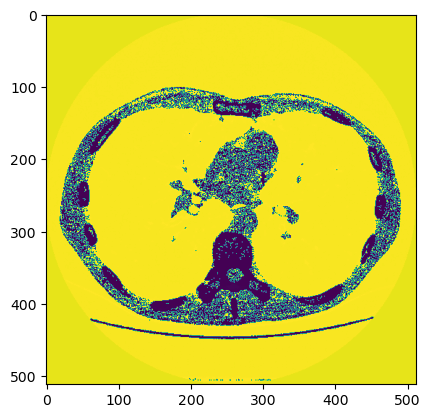

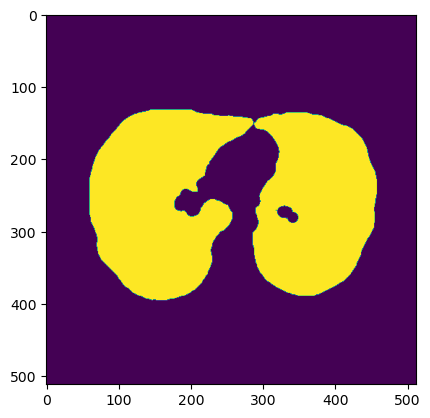

In [4]:
plt.imshow(train_images[0])
plt.show() 

plt.imshow(train_masks[0])
plt.show() 

**Q1b.2**: We will now implement data augmentation. As we can see from the previous part, we only have 160 training examples. Neural networks usually need large number of training examples to succeed in learning a task such as segmentation. Therefore, we will use data augmentation techniques to simulate exposing our model to many more training examples. We will use the following augmentations on our data:

1) Random horizontal shift with at most 0.1 of image width

2) Random vertical shift with at most 0.1 of image height

3) Random rotation with at most 10 degrees

4) Random zoom with at most 0.1 times zoom-in or zoom-out

Explain why these augmentations should help improve the accuracy of the model. Is it possible for data augmentation to instead decrease the performance of the trained model on the test set? If so, explain under what situation this could happen.

*Written answer*:



**Q1b.3**: For data augmentation in Keras, we will use the ```ImageDataGenerator``` class which has several built-in data augmentation methods. Look at the documentation of [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) and implement the following function. You only need to define `image_datagen` and `mask_datagen`.

The final print statement will check that your data generator is returning data with the right shape.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess(image, mask):
    image = tf.cast(image, tf.float32) / 255.0 
    mask = tf.cast(mask, tf.float32) / 255.0 
    return tf.image.resize(image, IMAGE_SIZE), tf.image.resize(mask, IMAGE_SIZE)

# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).shuffle(10000).batch(BATCH_SIZE).map(preprocess)
# test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks)).batch(BATCH_SIZE).map(preprocess)
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks)).batch(BATCH_SIZE).map(preprocess)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).map(preprocess).shuffle(10000).batch(BATCH_SIZE).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks)).map(preprocess).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks)).map(preprocess).batch(BATCH_SIZE)



# def create_generator(train_images, train_masks):
#     """ Creat a generator based on training images and masks.

#         Input:
#             train_images (np): array of training images
#             train_masks (np): array of training masks
#         Output:
#             data_generator (generator function): generator which yields images and masks after data augmenetation
#     """
#     # FILL IN CODE HERE #
#     data_gen_args = dict(rescale=1/255.0)
#     img_gen = ImageDataGenerator(**data_gen_args)
#     msk_gen = ImageDataGenerator(**data_gen_args)
#     # FILL IN CODE HERE #

#     img_gen.fit(train_images, augment=True, seed=SEED)
#     msk_gen.fit(train_masks, augment=True, seed=SEED)

#     image_generator = img_gen.flow(train_images, batch_size=BATCH_SIZE, seed=SEED)
#     mask_generator = msk_gen.flow(train_masks, batch_size=BATCH_SIZE, seed=SEED)
#     data_generator = zip(image_generator, mask_generator)


#     return data_generator

# data_generator = create_generator(train_images, train_masks)
# img, mask = next(data_generator)
# print(f"Image batch shape {img.shape}, mask batch shape {mask.shape}")


Run the following code to convert the generator (for the training set) and numpy arrays (for the validation and test sets) to TensorFlow datasets. Don't worry about the details; in part 3 of this assignment you will get practice writing generators for TensorFlow datasets.

In [6]:
# def train_generator():
#     while True:
#         image_batch, mask_batch = next(data_generator)
#         yield image_batch, mask_batch

# train_dataset = tf.data.Dataset.from_generator(train_generator,
#                      output_types=(tf.float32, tf.float32),
#                      output_shapes=([None, IMAGE_SIZE[0], IMAGE_SIZE[1], 1],
#                                     [None, IMAGE_SIZE[0], IMAGE_SIZE[1], 1])
#                                               ).repeat()
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks)).batch(BATCH_SIZE)
# test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks)).batch(BATCH_SIZE)

**Q1b.4**: Let's take a look at some image examples and their corresponding masks from the training dataset. Take a batch from the ```train_dataset``` and plot four images and their corresponding masks.

Shape :  (128, 128, 1)


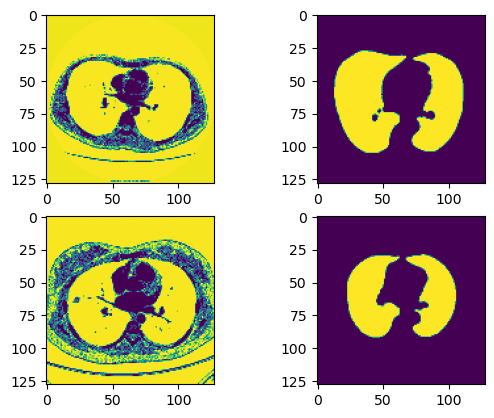

In [7]:
# FILL IN CODE HERE #
plt.subplot(221)
plt.imshow(train_dataset.unbatch().take(1).as_numpy_iterator().next()[0])

plt.subplot(222)
plt.imshow(train_dataset.unbatch().take(1).as_numpy_iterator().next()[1])

plt.subplot(223)
plt.imshow(train_dataset.unbatch().take(2).as_numpy_iterator().next()[0])

plt.subplot(224)
plt.imshow(train_dataset.unbatch().take(2).as_numpy_iterator().next()[1])


print('Shape : ', train_dataset.unbatch().take(1).as_numpy_iterator().next()[0].shape)
# FILL IN CODE HERE #

## Section 2: Model

Let's implement the Deeplab v1 model for our segmentation task. You can see the model architecture described in the Deeplab paper here: (arxiv.org/abs/1412.7062) , Figure 1. We'll be implementing a simpler version of this without a weighted loss for class imbalance.

**Q1b.5**: At a high level, explain how U-Net works and why it is more suitable for the segmentation task relative to a simple convolutional neural network (CNN).


*Written answer*:

**Q1b.6**: Implement a simplified version of Deeplab based on thesis.


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate, UpSampling2D

def deeplabv1(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    up1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(pool2)
    up1 = UpSampling2D((2, 2))(up1)  # Add this line
    up1 = Concatenate()([up1, conv1])
    conv3 = Conv2D(64, 3, padding='same')(up1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(64, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv3)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
num_classes = 2
model = deeplabv1(input_shape, num_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 64)         0         ['batch_normalization[0][0

In [11]:
from tensorflow.keras.layers import Layer, Conv2D, MaxPool2D, UpSampling2D, Dropout, concatenate, Dense, Flatten, BatchNormalization, ReLU, MaxPooling2D

class Deeplabv1(tf.keras.Model):
    def __init__(self):
        # super(Deeplabv3, self).__init__()
        super(Deeplabv1, self).__init__()

        # FILL IN CODE HERE #
        # Simple CNN Backbone
        self.conv1 = 0
        # self.conv1 = Conv2D(64, 3, padding='same')
        # self.conv2 = Conv2D(128, 3, padding='same')
        # self.convTranspose = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')
        # self.upsampling = UpSampling2D((2, 2))
        # self.batch_norm = BatchNormalization()
        # self.relu = Activation('relu')
        # self.pool = MaxPooling2D(pool_size=(2, 2))
        # self.conv3 = Conv2D(1, (1, 1), activation='sigmoid')

        # Decoder
        # up1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(pool2)
        # up1 = UpSampling2D((2, 2))(up1)  # Add this line
        # up1 = Concatenate()([up1, conv1])
        # conv3 = Conv2D(64, 3, padding='same')(up1)
        # conv3 = BatchNormalization()(conv3)
        # conv3 = Activation('relu')(conv3)
        # conv3 = Conv2D(64, 3, padding='same')(conv3)
        # conv3 = BatchNormalization()(conv3)
        # conv3 = Activation('relu')(conv3)
        # outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv3)
        

        # FILL IN CODE HERE #
    # conv1 = Conv2D(64, 3, padding='same')(inputs)
    # conv1 = BatchNormalization()(conv1)
    # conv1 = Activation('relu')(conv1)
    # conv1 = Conv2D(64, 3, padding='same')(conv1)
    # conv1 = BatchNormalization()(conv1)
    # conv1 = Activation('relu')(conv1)
    # pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # conv2 = Conv2D(128, 3, padding='same')(pool1)
    # conv2 = BatchNormalization()(conv2)
    # conv2 = Activation('relu')(conv2)
    # conv2 = Conv2D(128, 3, padding='same')(conv2)
    # conv2 = BatchNormalization()(conv2)
    # conv2 = Activation('relu')(conv2)
    # pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # # Decoder
    # up1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(pool2)
    # up1 = UpSampling2D((2, 2))(up1)  # Add this line
    # up1 = Concatenate()([up1, conv1])
    # conv3 = Conv2D(64, 3, padding='same')(up1)
    # conv3 = BatchNormalization()(conv3)
    # conv3 = Activation('relu')(conv3)
    # conv3 = Conv2D(64, 3, padding='same')(conv3)
    # conv3 = BatchNormalization()(conv3)
    # conv3 = Activation('relu')(conv3)

    # outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv3)

    def call(self, inputs):
        
        # FILL IN CODE HERE #
        # x = self.conv1(inputs)
        # x = self.batch_norm(x)
        # x = self.relu(x)
        # x = self.conv1(inputs)
        # x = self.batch_norm(x)
        # x = self.relu(x)
        x = 0
        # FILL IN CODE HERE #
        return x

# create model
# model = Deeplabv1()

# test that the output data shape is reasonable
# img_batch, mask_batch = next(iter(test_dataset))
# print(test_dataset)
# sample_out = model(test_dataset)
# print(f"Input shape {img_batch.shape}, model out shape {sample_out.shape}")
# model.build((None, 256, 256, 1)) 
# model.summary()

**Q1b.7**: Which loss function do you think is most appropriate for our task here? Why? After selecting the loss function, compile the model using the Adam optimizer with default learning rate. Add the accuracy metric.

(Note that the UNet paper describes a special weighting coefficient that makes its loss function different to the one you may choose; you don't have to implement this weighting.)

*Written answer*:

In [12]:
# FILL IN CODE HERE #
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# FILL IN CODE HERE #

**Q1b.8**: Before training the model, let's first set a learning rate scheduler. This will adjust the learning rate during the training of the model. Why can it be useful to use a learning rate schedule to train complex neural networks?

*Written answer*:

Now we are going to train our model for 40 epochs. Implement the following function such that the learning rate for the first 20 epochs is 0.001, and after that it decreases exponentially with a factor of 0.1. For more information, please look at the ```ExponentialDecay``` documentation in Keras.

In [13]:
def scheduler(epoch):
    """ Schedule the learning rate to be 0.0001 for first
        20 epoch, and decrease exponentially by a factor of 0.1
        for all remaining epochs.

        Input:
            epoch (int)
        Output:
            learning_rate (float)
    """
    # FILL IN CODE HERE #
    if epoch < 20:
        learning_rate = 0.0001
    else:
        learning_rate = 0.0001 * tf.math.exp(0.1 * (20 - epoch))
        
    return learning_rate
    # FILL IN CODE HERE #

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)


**Q1b.9**: Train the model using the ```model.fit``` function in the Keras API. We compute the value of `steps_per_epoch` which tells the API how many times to sample from the TensorFlow dataset object. It should be passed as an argument to `model.fit()`. To enable the learning rate schedule we just implemented, pass it as a callback to `model.fit`.

In [16]:
steps_per_epoch = int(len(os.listdir(IMAGE_DIR)) * TRAIN_VAL_TEST_SPLIT[0]) // BATCH_SIZE # pass this arg to fit()


hist = model.fit(
    # FILL IN CODE HERE #
    train_dataset,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    # steps_per_epoch=EVALUATION_INTERVAL,
    callbacks=[lr_scheduler],
    validation_data=val_dataset
    # FILL IN CODE HERE #
)

Epoch 1/100


/Users/sehwanyoo/miniconda3/envs/tf_conda/lib/python3.10/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 5s 384ms/step - loss: 0.4876 - accuracy: 0.7680 - val_loss: 0.6928 - val_accuracy: 0.4665 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - 4s 363ms/step - loss: 0.3628 - accuracy: 0.8622 - val_loss: 0.6992 - val_accuracy: 0.4389 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - 4s 357ms/step - loss: 0.2747 - accuracy: 0.9007 - val_loss: 0.6860 - val_accuracy: 0.5022 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - 4s 353ms/step - loss: 0.2233 - accuracy: 0.9143 - val_loss: 0.6182 - val_accuracy: 0.6862 - lr: 1.0000e-04
Epoch 5/100
10/10 [==============================] - 3s 349ms/step - loss: 0.1989 - accuracy: 0.9264 - val_loss: 0.5448 - val_accuracy: 0.7591 - lr: 1.0000e-04
Epoch 6/100
10/10 [==============================] - 3s 353ms/step - loss: 0.1706 - accuracy: 0.9397 - val_loss: 0.5331 - val_accuracy: 0.7591 - lr: 1.0000e-04
Epoch 7/100
10/10 [==============================] -

Using the `hist` variable returned from running the `fit` command above, run the following code to plot the training and validation loss.

In [19]:
len(hist.history['loss']), EPOCHS

(100, 40)

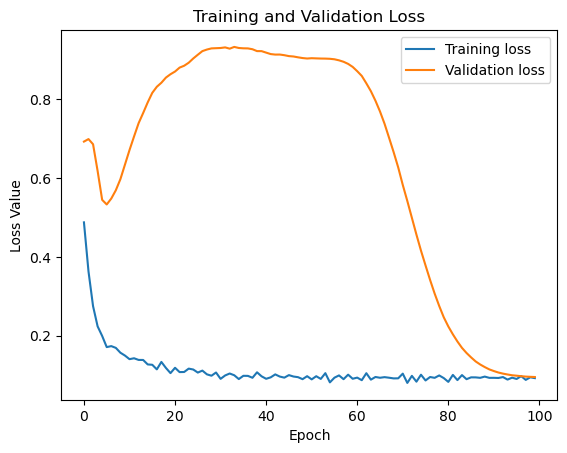

In [20]:
plt.figure()
# plt.plot(range(EPOCHS), hist.history['loss'], label='Training loss')
# plt.plot(range(EPOCHS), hist.history['val_loss'], label='Validation loss')
plt.plot(range(len(hist.history['loss'])), hist.history['loss'], label='Training loss')
plt.plot(range(len(hist.history['val_loss'])), hist.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

## Section 3: Evaluation

**Q1b.10**: Use ```model.evaluate``` to evaluate the accuracy of the model on the test set. You should have an accuracy greater than 0.9.

In [21]:
model.evaluate(test_dataset)

4/4 [==============================] - 1s 118ms/step - loss: 0.0873 - accuracy: 0.9639


[0.08730960637331009, 0.9639045000076294]

**Q1b.11**: Based on the loss and accuracy on the test set, do you think we are overfitting? Please describe three methods that can be used to avoid overfitting.

*Written answer*:

**Q1b.12**: What is Intersection over Union (IoU) and why it is a useful metric for the segmentation task?
Implement the following function using the definition of IoU. Note that the ```np.logical_and``` and ```np.logical_or``` could be useful.

*Written answer*:

In [22]:
def compute_IoU(target, prediction):
    """
    Evaluate the intersection over union score for a single prediction and ground truth value

    Parameters:
    target: (np.ndarray) : The ground truth label values
    prediction (np.ndarray): The labels predicted by the model
    """
    # FILL IN CODE HERE #
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou = np.sum(intersection) / np.sum(union)
    
    # FILL IN CODE HERE #
    return iou

**Q1b.13**: Using the `compute_IoU` function, compute the mean IoU on the test set and print the result. Compute the IoU for each image separately, and then take the mean over images. You can binarize the prediction mask with a threshold of 0.1.

In [35]:
# FILL IN CODE HERE #
real_test_img = test_dataset.unbatch().take(1).as_numpy_iterator().next()[0]
pred_test_img = model.predict(real_test_img[tf.newaxis, ...])
# print(test_img.shape)
# compute_IoU(test_masks[0], test_masks[0])

# FILL IN CODE HERE #

1/1 [==============================] - 0s 26ms/step


**Q1b.14**: Let's make some predictions! Plot four test images, their corresponding ground truth mask, and the model prediction. Make sure to show at least one image for each of the IoU ranges of [0.85, 0.9], [0.9, 0.95], and [0.95, 1].

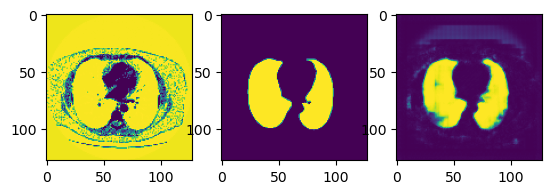

In [39]:
# FILL IN CODE HERE #
plt.subplot(131)
plt.imshow(real_test_img)

plt.subplot(132)
plt.imshow(test_dataset.unbatch().take(1).as_numpy_iterator().next()[1])

plt.subplot(133)
plt.imshow(pred_test_img.squeeze(axis=0))

# FILL IN CODE HERE #